# TLDR: 
Use this notebook to run the Canopy Height Model on an input RGB image. 


# Details: 
- The input RGB image should be in topocentric coordinates, with a pixel ground sample distance (GSD) of 0.6m.
- The data type is Uint8, with nodata set to 255.
- For a ~5000x5000 image, inference runs in ~10mins on a M3 Mac.
- The final product is a geotiff of canopy height, in units of meters. Nodata is assigned as np.NaN

# Reference 
https://sustainability.atmeta.com/blog/2024/04/22/using-artificial-intelligence-to-map-the-earths-forests/

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
from tqdm.notebook import tqdm

import boto3
from botocore import UNSIGNED
from botocore.config import Config

import rasterio
from rasterio.windows import Window

import torch
from torch.utils.data import DataLoader, Dataset
torch.backends.quantized.engine = 'qnnpack'
import pytorch_lightning as pl

#local modules
import sys
sys.path.append('../')
import src.transforms as transforms
import src.raster_utils as raster_utils
from inference import SSLAE
import argparse
import os
import torch
import pandas as pd
import numpy as np
import torchvision.transforms as T
import matplotlib.pyplot as plt
import torchmetrics
from pathlib import Path
import torch.nn as nn
from tqdm import tqdm
from PIL import Image
import math
import torchvision.transforms.functional as TF
import torchvision
from torchvision.utils import save_image

from models.backbone import SSLVisionTransformer
from models.dpt_head import DPTHead
import pytorch_lightning as pl
from models.regressor import RNet

In [2]:
class CustomImageDataset(Dataset):
    def __init__(self, stack, transform=None) -> None:
        self.len = stack.shape[0]
        self.transform = transform
        self.stack = stack
        self.im_shape = stack.shape[1:]

    def __len__(self):
        return self.len

    def __getitem__(self, idx):
        self.idx = idx
        im = self.stack[idx]
        if self.transform:
            im = self.transform(im)

        data = {"image": im}
        return data

In [3]:

class SSLAE(nn.Module):
    def __init__(self, pretrained=None, classify=True, n_bins=256, huge=False):
        super().__init__()
        if huge == True:
            self.backbone = SSLVisionTransformer(
            embed_dim=1280,
            num_heads=20,
            out_indices=(9, 16, 22, 29),
            depth=32,
            pretrained=pretrained
            )
            self.decode_head = DPTHead(
                classify=classify,
                in_channels=(1280, 1280, 1280, 1280),
                embed_dims=1280,
                post_process_channels=[160, 320, 640, 1280],
            )  
        else:
            self.backbone = SSLVisionTransformer(pretrained=pretrained)
            self.decode_head = DPTHead(classify=classify,n_bins=256)
        
    def forward(self, x):
        x = self.backbone(x)
        x = self.decode_head(x) 
        return x

class SSLModule(pl.LightningModule):
    def __init__(self, 
                  ssl_path="compressed_SSLbaseline.pth"):
        super().__init__()
    
        if 'huge' in ssl_path:
            self.chm_module_ = SSLAE(classify=True, huge=True).eval()
        else:
            self.chm_module_ = SSLAE(classify=True, huge=False).eval()
        
        if 'compressed' in ssl_path:   
            ckpt = torch.load(ssl_path, map_location='cpu')
            self.chm_module_ = torch.quantization.quantize_dynamic(
                self.chm_module_, 
                {torch.nn.Linear,torch.nn.Conv2d,  torch.nn.ConvTranspose2d},
                dtype=torch.qint8)
            self.chm_module_.load_state_dict(ckpt, strict=False)
        else:
            ckpt = torch.load(ssl_path)
            state_dict = ckpt['state_dict']
            self.chm_module_.load_state_dict(state_dict)
        
        # self.chm_module = lambda x: 10*self.chm_module_(x)
        
    # def forward(self, x):
    #     x = self.chm_module(x)
    #     return x
    
    def predict(self, batch):
        device = next(self.chm_module_.parameters()).device
        x = batch["image"].to(device)
        outputs = self.chm_module_(x)
        pred = 10 * outputs + 0.001
        pred = pred.relu()
        return pred, outputs

In [75]:
def run_inference_blocks(img, model, winsize=256):
    #this is how we breakup large images into batches for model inference
    step = int(winsize * 3 / 4)
    stack, vx, vy = raster_utils.blocking(img, (winsize, winsize, 3), step)

    transform = transforms.SSLNorm().Trans

    data = CustomImageDataset(stack, transform=transform)
    dl = DataLoader(data, shuffle=False, batch_size=stack.shape[0])
    batch = next(iter(dl))
    
    output, _ = model.predict(batch)
    weight = raster_utils.create_apodization((winsize, winsize))


    pred_stack = output.detach().numpy().squeeze()
    pred_stack = np.expand_dims(pred_stack, -1)
    out_size = img.shape[0:2]
    pred_im, weights = raster_utils.inverse_blocking(
        pred_stack, out_size, winsize, weight, step, vx, vy
    )
    pred_im = pred_im.squeeze()
    return pred_im


def windowed_infer_loop(image_path, model, out_path=None, window_size=1024):
    #suggested window sizes: 448, 1024
    if not out_path:
        out_path=image_path.replace('.tif', '_chm.tif')
    with rasterio.open(image_path) as src:
        meta=src.meta
        meta.update({'count':1,
                     "dtype": np.float32,
                     "driver":'GTiff',
                     "nodata": np.nan,
                     })
        print("Opened input image")
        with rasterio.open(out_path, 'w', **meta) as dst:
            print("Opened output image")
            
            row_coords=list(np.arange(0,src.height,window_size)[:-1])+[src.height-window_size]
            col_coords=list(np.arange(0,src.width,window_size)[:-1])+[src.width-window_size]
            print("Processing...")
            for row in tqdm(row_coords, desc="inference_progress", position=0):
                for col in col_coords:
                    window = Window(col, row, window_size, window_size)
                    data = src.read(window=window)
                    mask=src.read_masks(1, window=window)
                    image = np.moveaxis(data, 0, -1)
                    chm_block=run_inference_blocks(image, model)
                    chm_block=chm_block.astype(meta['dtype'])
                    chm_block[~mask==src.nodata]=meta['nodata']
                    dst.write(chm_block, window=window, indexes=1)
            
    return out_path

# Run model on RGB demo image

In [7]:
#get model
s3_client = boto3.client('s3', config=Config(signature_version=UNSIGNED))
bucket='dataforgood-fb-data'
localdir='data'
# s3file='forests/v1/models/saved_checkpoints/compressed_SSLhuge.pth'
# local_model_file=f"{localdir}/{os.path.basename(s3file)}"
# if not os.path.exists(local_model_file):
#     s3_client.download_file(bucket, s3file, local_model_file)

In [8]:
#get rgb example image
#pixel size needs to be square, 0.6m GSD
#recommendation is to convert to topocentric coordinates or UTM

s3file='forests/v1/examples/CA_subset_rgb_polygon.tif'
local_rgb_file=f"{localdir}/{os.path.basename(s3file)}"
if not os.path.exists(local_rgb_file):
    s3_client.download_file(bucket, s3file, local_rgb_file)

In [9]:
#load model
# checkpoint="/mnt/data2tb/HighResCanopyHeight/saved_checkpoints/compressed_SSLhuge.pth"
checkpoint="/mnt/data2tb/HighResCanopyHeight/saved_checkpoints/SSLhuge_satellite.pth"
model=SSLModule(checkpoint)
model.eval();

/tmp/ipykernel_4226/3530435534.py:45: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  ckpt = torch.load(ssl_path)


In [ ]:
# s3file='forests/v1/examples/CA_subset_rgb_polygon.tif'
# local_rgb_file=f"{localdir}/{os.path.basename(s3file)}"

# data.shape

In [82]:
#run model on example rgb image
local_rgb_file="/mnt/data2tb/HighResCanopyHeight/SR_img/clipped/clipped119_2.tif"
chm_path=windowed_infer_loop(local_rgb_file, model, window_size=1024)

Opened input image
Opened output image
Processing...


inference_progress: 100%|██████████| 10/10 [32:37<00:00, 195.71s/it]


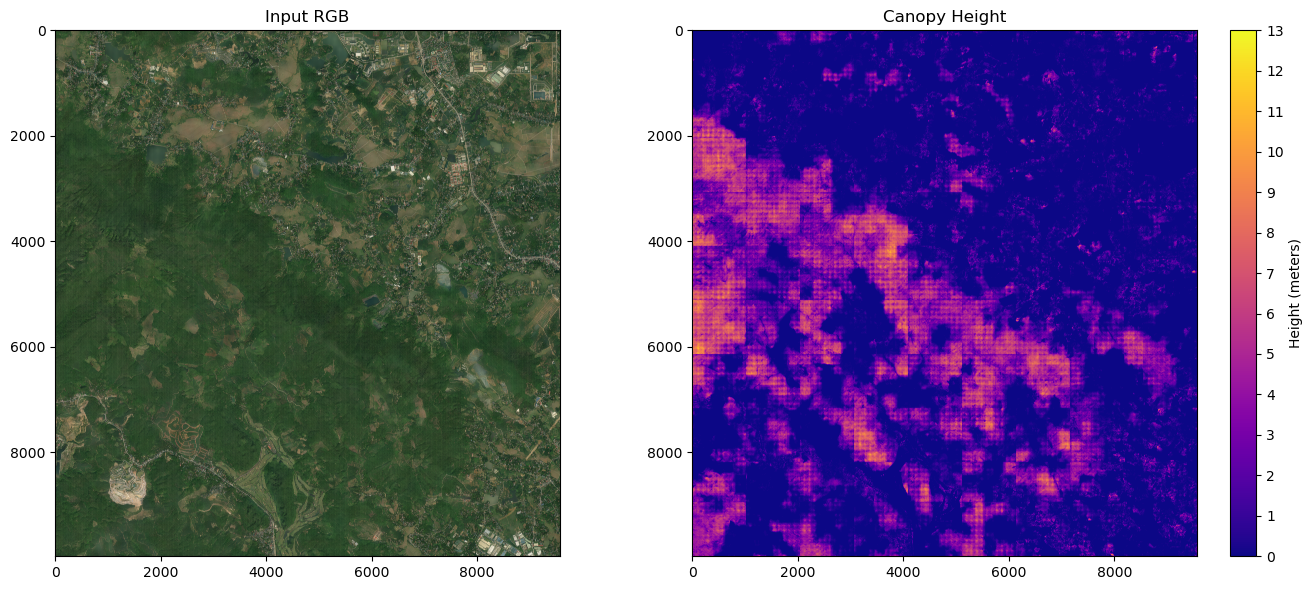

In [85]:
import matplotlib.pyplot as plt
import numpy as np
import rasterio

with rasterio.open(local_rgb_file) as src:
    data = src.read()
    image = np.moveaxis(data[0:3], 0, -1)

with rasterio.open(chm_path) as src:
    chm = src.read().squeeze()

plt.figure(figsize=(14, 6))

plt.subplot(1, 2, 1)
plt.imshow(image)
plt.title('Input RGB')
# plt.axis('off')  # Optional: Remove axes for cleaner visualization

# mask = ~np.isnan(chm) & (chm < 200)
plt.subplot(1, 2, 2)

chm_max_height = np.max(chm[~np.isnan(chm) & (chm < 200)])
vmax = int(chm_max_height) + 1
im = plt.imshow(chm, vmin=0, vmax=vmax, cmap='plasma')  # Specify cmap for clarity
plt.title('Canopy Height')
# plt.axis('off')  # Optional: Remove axes for cleaner visualization

# Add colorbar for CHM
cbar = plt.colorbar(im, ax=plt.gca(), label='Height (meters)')
cbar.set_ticks(np.arange(0, vmax+1, 1))  # Optional: Set specific ticks for clarity

plt.tight_layout()  # Adjust layout to prevent overlap
# plt.savefig('rgb_chm_visualization.png')